## Package Installation

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check correct hostname
!hostname

node062


## Imports

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torchaudio.transforms import MelSpectrogram, Spectrogram
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from sklearn.preprocessing import RobustScaler
from scipy.io import loadmat
from scipy.signal import resample
from mne.filter import filter_data
import matplotlib.pyplot as plt
import wandb
import os
from pathlib import Path
from tqdm import tqdm
from time import time

## Helper Functions/Classes

In [5]:
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a


# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = lfilter(b, a, data)
#     return y


def downsample(x, sf, new_sf):
    num = int(new_sf / sf * x.shape[-1])
    return resample(x, num, axis=-1)


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self


class SleepDataset(Dataset):
    def __init__(
        self,
        data_dir,
        raw_sf,
        model_sf,
        raw_epoch_len,
        model_epoch_len,
        homemade,
        *,
        run_preproc=False,
        bandpass_freqs=None,
        context_window=1,
        eeg_idx=0,
        emg_idx=5,
        random_shift=False,
        eeg_transform=None,
        emg_transform=None,
        target_transform=None
    ):
        # Build the paths
        all_paths = list(Path(data_dir).glob("**/*"))
        all_dirs = sorted([folder for folder in all_paths if folder.is_dir()])
        if not all_dirs:
            all_dirs = [Path(data_dir)]
        # self.sf = sf
        # self.epoch_len = epoch_len
        assert (
            float(raw_sf * raw_epoch_len).is_integer()
            and float(model_sf * model_epoch_len).is_integer()
        )
        self.window_size = int(model_sf * model_epoch_len)
        self.raw_sf = raw_sf
        self.model_sf = model_sf
        self.raw_epoch_len = raw_epoch_len
        self.model_epoch_len = model_epoch_len
        assert context_window >= 1
        self.context_window = context_window
        self.random_shift = random_shift
        self.eeg_transform = eeg_transform
        self.emg_transform = emg_transform
        self.target_transform = target_transform

        self.eegs = []
        self.emgs = []
        self.labels = []
        index_map = []
        dir_map = []
        i_map = 0
        for dir in tqdm(all_dirs, desc="Loading Data"):
            try:
                if run_preproc:
                    self.preprocess(dir, homemade, raw_sf, model_sf, bandpass_freqs)
                eeg, emg, label = self.get_preproc_files(
                    dir, homemade, eeg_idx, emg_idx
                )
            except FileNotFoundError:
                continue

            self.eegs.append(eeg)
            self.emgs.append(emg)
            self.labels.append(label)
            dir_map.append(np.repeat(i_map, len(label) - self.context_window + 1))
            index_map.append(np.arange(self.context_window - 1, len(label)))
            i_map += 1
        if len(dir_map) == 0:
            raise FileNotFoundError

        dir_map = np.concatenate(dir_map)
        index_map = np.concatenate(index_map)
        self.index_map = np.column_stack((dir_map, index_map))

    def get_preproc_files(self, data_dir, homemade, eeg_idx, emg_idx):
        """Retrieves EEG, EMG, and label data

        Args:
            data_dir (str): directory in which data is stored

        Raises:
            FileNotFoundError: raised if EEG.mat, EMG.mat, or labels.mat do not exist within target_folder

        Returns:
            eeg_array, emg_array, label_array (torch.Tensor, torch.Tensor, torch.Tensor): EEG, EMG, and label data
            as numpy arrays
        """
        if homemade:
            eeg_emg_file = os.path.join(data_dir, "EEG-EMG_preproc.npy")
            label_file = os.path.join(data_dir, "labels_preproc.npy")

            paths_are_files = list(
                map(lambda x: os.path.isfile(x), [eeg_emg_file, label_file])
            )
            if not all(paths_are_files):
                raise FileNotFoundError
            # load files
            eeg_emg = np.load(eeg_emg_file)
            label = np.load(label_file)

            eeg, emg = eeg_emg[eeg_idx], eeg_emg[emg_idx]
        else:
            eeg_file = os.path.join(data_dir, "EEG_preproc.npy")
            emg_file = os.path.join(data_dir, "EMG_preproc.npy")
            label_file = os.path.join(data_dir, "labels_preproc.npy")

            paths_are_files = list(
                map(lambda x: os.path.isfile(x), [eeg_file, emg_file, label_file])
            )
            if not all(paths_are_files):
                raise FileNotFoundError
            # load files
            eeg = np.load(eeg_file)
            emg = np.load(emg_file)
            label = np.load(label_file)

        # Check lengths
        assert eeg.shape[0] == emg.shape[0]
        num_eeg_samples = eeg.shape[0] / self.window_size
        assert num_eeg_samples >= len(label)

        eeg = eeg[: len(label) * self.window_size]
        emg = emg[: len(label) * self.window_size]

        return (
            torch.tensor(eeg, dtype=torch.float),
            torch.tensor(emg, dtype=torch.float),
            torch.tensor(label, dtype=torch.long),
        )

    def preprocess(
        self,
        data_dir,
        homemade,
        raw_sf,
        model_sf,
        bandpass_freqs,
    ):
        if homemade:
            eeg_emg_file = os.path.join(data_dir, "EEG-EMG.npy")
            label_file = os.path.join(data_dir, "labels.npy")

            paths_are_files = list(
                map(lambda x: os.path.isfile(x), [eeg_emg_file, label_file])
            )
            if not all(paths_are_files):
                raise FileNotFoundError
            # load files
            eeg_emg = np.load(eeg_emg_file)
            label = np.load(label_file)

            if bandpass_freqs:
                eeg_emg = filter_data(
                    eeg_emg.astype("float64"),
                    raw_sf,
                    bandpass_freqs[0],
                    bandpass_freqs[1],
                    verbose=0,
                )
            if raw_sf != model_sf:
                eeg_emg = downsample(eeg_emg, raw_sf, model_sf)

            # Scale EEG and EMG
            eeg_emg = RobustScaler().fit_transform(eeg_emg.T).T  # type: ignore

            num_samples = int(eeg_emg.shape[1] // (model_sf * self.raw_epoch_len))
            assert num_samples == len(label)

            if self.raw_epoch_len != self.model_epoch_len:
                label_new_len = int(
                    len(label) * self.raw_epoch_len // self.model_epoch_len
                )
                eeg_emg = eeg_emg[
                    : int(label_new_len * model_sf * self.model_epoch_len)
                ]

            np.save(os.path.join(data_dir, "EEG-EMG_preproc.npy"), eeg_emg)
        else:
            eeg_file = os.path.join(data_dir, "EEG.mat")
            emg_file = os.path.join(data_dir, "EMG.mat")
            label_file = os.path.join(data_dir, "labels.mat")

            paths_are_files = list(
                map(lambda x: os.path.isfile(x), [eeg_file, emg_file, label_file])
            )
            if not all(paths_are_files):
                raise FileNotFoundError
            # load files
            eeg = loadmat(eeg_file)
            emg = loadmat(emg_file)
            label = loadmat(label_file)

            eeg = np.squeeze(eeg["EEG"])
            emg = np.squeeze(emg["EMG"])
            label = np.squeeze(label["labels"])

            assert eeg.shape[0] == emg.shape[0]

            if bandpass_freqs:
                eeg = filter_data(
                    eeg.astype("float64"),
                    raw_sf,
                    bandpass_freqs[0],
                    bandpass_freqs[1],
                    verbose=0,
                )
                emg = filter_data(
                    emg.astype("float64"),
                    raw_sf,
                    bandpass_freqs[0],
                    bandpass_freqs[1],
                    verbose=0,
                )
            if raw_sf != model_sf:
                eeg = downsample(eeg, raw_sf, model_sf)
                emg = downsample(emg, raw_sf, model_sf)

            # Scale EEG and EMG
            eeg = RobustScaler().fit_transform(eeg[:, np.newaxis]).squeeze()  # type: ignore
            emg = RobustScaler().fit_transform(emg[:, np.newaxis]).squeeze()  # type: ignore
            
            num_samples = int(eeg.shape[0] // (model_sf * self.raw_epoch_len))
            assert num_samples == len(label)

            if self.raw_epoch_len != self.model_epoch_len:
                label_new_len = int(
                    len(label) * self.raw_epoch_len // self.model_epoch_len
                )
                eeg = eeg[: int(label_new_len * model_sf * self.model_epoch_len)]
                emg = emg[: int(label_new_len * model_sf * self.model_epoch_len)]

            np.save(os.path.join(data_dir, "EEG_preproc.npy"), eeg)
            np.save(os.path.join(data_dir, "EMG_preproc.npy"), emg)

        accusleep_dict = {
            1: 2,  # "R",
            2: 0,  # "W",
            3: 1,  # "N"
        }
        # re-map the label values
        label_df = pd.DataFrame({"label": label})
        label_df["label"] = label_df["label"].map(accusleep_dict)
        label = label_df["label"].values

        if self.raw_epoch_len != self.model_epoch_len:
            label_new = np.zeros(label_new_len, dtype=int)  # type: ignore
            for i in range(len(label_new)):
                label_new[i] = label[
                    int(round(i * self.model_epoch_len / self.raw_epoch_len))
                ]
            label = label_new

        np.save(os.path.join(data_dir, "labels_preproc.npy"), label)  # type: ignore

    def __len__(self):
        return self.index_map.shape[0]

    def __getitem__(self, idx):
        dir_idx, adjusted_idx = self.index_map[idx]
        label = self.labels[dir_idx][adjusted_idx]
        if self.random_shift and adjusted_idx < len(self.labels[dir_idx]) - 1:
            offset = np.random.randint(self.window_size)
        else:
            offset = 0
        low = (adjusted_idx - self.context_window + 1) * self.window_size + offset
        high = (adjusted_idx + 1) * self.window_size + offset
        eeg = self.eegs[dir_idx][low:high]
        emg = self.emgs[dir_idx][low:high]
        if self.eeg_transform:
            eeg = self.eeg_transform(eeg)
        if self.emg_transform:
            emg = self.emg_transform(emg)
        if self.target_transform:
            label = self.target_transform(label)
        x = torch.stack((eeg, emg), dim=0)
        return x, label

## Parameters

In [6]:
params = AttrDict(
    # Data
    train_data_dir = 'data/24-hour_recordings',
    test_data_dir = 'data/4-hour_recordings',
    sample_data_dir = 'data/4-hour_recordings/Mouse01/Day1',
    homemade_data_dir = 'data/homemade_recordings',
    pretrained_model_dir = 'models',
    finetuned_model_dir = 'ft_models',
    homemade_eeg_idx = 4,
    homemade_emg_idx = 5,
    model_sf = 128,
    accusleep_sf = 512, # Hz
    homemade_sf = 1000, # Hz
    bandpass_freqs = [1, 64],
    run_preproc = False,
    homemade_epoch_len = 2.0, # sec
    accusleep_epoch_len = 2.5, # sec
    model_epoch_len = 2.5, # sec
    context_window = 3,
    random_shift = True,
    eeg_transform = None,
    emg_transform = None,
    target_transform = None,
    
    # Model
    in_dim = 2,
    out_dim = 3,
    embed_dim = 32,
    feedforward_dim = 128,
    do_pos_embed = True,
    pos_embed_dim = 16,
    dim_blocks = [16, 32, 32, 32],
    res_blocks = [True, True, True, True],
    attn_blocks = [False, False, True, True],
    num_heads = 8,
    kernel_size = 3,
    activation = nn.GELU,
    dropout = 0.0,
    log_wandb = True,
    
    # Training
    criterion = nn.CrossEntropyLoss(),
    optimizer = optim.Adam,
    lr = 0.001,
    num_epochs = 30,
    num_epochs_ft = 100,
    batch_size = 16,
    log_freq = 50,
    val_batches=50
)
try:
    os.mkdir(params.pretrained_model_dir)
except FileExistsError:
    pass
try:
    os.mkdir(params.finetuned_model_dir)
except FileExistsError:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [7]:
train_data = SleepDataset(
    params.train_data_dir,
    params.accusleep_sf,
    params.model_sf,
    params.accusleep_epoch_len,
    params.model_epoch_len,
    False,
    run_preproc=params.run_preproc,
    bandpass_freqs=params.bandpass_freqs,
    context_window=params.context_window,
    random_shift=params.random_shift,
    eeg_transform=params.eeg_transform,
    emg_transform=params.emg_transform,
    target_transform=params.target_transform
)

test_data = SleepDataset(
    params.test_data_dir,
    params.accusleep_sf,
    params.model_sf,
    params.accusleep_epoch_len,
    params.model_epoch_len,
    False,
    run_preproc=params.run_preproc,
    bandpass_freqs=params.bandpass_freqs,
    context_window=params.context_window,
    random_shift=params.random_shift,
    eeg_transform=params.eeg_transform,
    emg_transform=params.emg_transform,
    target_transform=params.target_transform
)

homemade_train_data = SleepDataset(
    params.homemade_data_dir,
    params.homemade_sf,
    params.model_sf,
    params.homemade_epoch_len,
    params.model_epoch_len,
    True,
    run_preproc=params.run_preproc,
    bandpass_freqs=params.bandpass_freqs,
    context_window=params.context_window,
    eeg_idx=params.homemade_eeg_idx,
    emg_idx=params.homemade_emg_idx,
    random_shift=params.random_shift,
    eeg_transform=params.eeg_transform,
    emg_transform=params.emg_transform,
    target_transform=params.target_transform
)

homemade_test_data = SleepDataset(
    params.homemade_data_dir,
    params.homemade_sf,
    params.model_sf,
    params.homemade_epoch_len,
    params.model_epoch_len,
    True,
    run_preproc=params.run_preproc,
    bandpass_freqs=params.bandpass_freqs,
    context_window=params.context_window,
    eeg_idx=9,
    emg_idx=10,
    random_shift=params.random_shift,
    eeg_transform=params.eeg_transform,
    emg_transform=params.emg_transform,
    target_transform=params.target_transform
)

sample_data = SleepDataset(
    params.sample_data_dir,
    params.accusleep_sf,
    params.model_sf,
    params.accusleep_epoch_len,
    params.model_epoch_len,
    False,
    run_preproc=params.run_preproc,
    bandpass_freqs=params.bandpass_freqs,
    context_window=params.context_window,
    random_shift=params.random_shift,
    eeg_transform=params.eeg_transform,
    emg_transform=params.emg_transform,
    target_transform=params.target_transform
)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


In [8]:
train_loader = DataLoader(
    train_data, 
    params.batch_size,
    shuffle=True,
    pin_memory=True if device == torch.device("cuda") else False
)

test_loader = DataLoader(
    test_data,
    params.batch_size,
    shuffle=False,
    pin_memory=True if device == torch.device("cuda") else False
)

indices = np.random.choice(len(test_data), params.val_batches*params.batch_size, replace=False)
val_sampler = SubsetRandomSampler(indices)
val_loader = DataLoader(
    test_data,
    params.batch_size,
    sampler=val_sampler,
    pin_memory=True if device == torch.device("cuda") else False
)

sample_loader = DataLoader(
    sample_data,
    params.batch_size,
    shuffle=False,
    pin_memory=True if device == torch.device("cuda") else False
)

homemade_train_loader = DataLoader(
    homemade_train_data,
    params.batch_size,
    shuffle=True,
    pin_memory=True if device == torch.device("cuda") else False
)

homemade_test_loader = DataLoader(
    homemade_test_data,
    params.batch_size,
    shuffle=False,
    pin_memory=True if device == torch.device("cuda") else False
)

params.input_shape = next(iter(train_loader))[0].shape

## 1D Convolutional Attention Model

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same")
        self.activation = activation()
        self.downsample = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
        self.norm1 = nn.LayerNorm(in_channels)
        self.norm2 = nn.LayerNorm(out_channels)

    def forward(self, x):
        res = self.downsample(x)
        x = self.norm1(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.norm2(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.conv2(x)
        return x + res


class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, do_ln, activation):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim) if do_ln else nn.Identity()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.activation = activation()
        self.linear2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x


def positional_encoding(length, depth):
    original_depth = depth
    if depth % 2 != 0:
        depth += 1
    depth /= 2

    positions = np.arange(length)[:, np.newaxis]  # (length, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rads = positions / (10000**depths)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)[
        :, :original_depth
    ]

    return torch.Tensor(pos_encoding)


class PositionalEmbedding(nn.Module):
    def __init__(self, seq_length, out_dim, ff_dim, activation):
        super().__init__()
        pos_encoding = positional_encoding(seq_length, out_dim)[None, :, :]
        self.pos_encoding = nn.Parameter(pos_encoding, requires_grad=False)
        self.ffn = FeedForward(out_dim, ff_dim, out_dim, False, activation)

    def forward(self, x):
        x = x.transpose(1,2)
        x += self.ffn(self.pos_encoding)
        return x.transpose(1,2)


class AttentionBlock(nn.Module):
    def __init__(
        self, in_dim, embed_dim, num_heads, feedforward_dim, activation, dropout
    ):
        super().__init__()
        self.qkv = nn.Linear(in_dim, embed_dim * 3)
        self.attention = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.feed_forward = FeedForward(
            in_dim, feedforward_dim, in_dim, True, activation
        )
        self.proj = (
            nn.Linear(embed_dim, in_dim) if in_dim != embed_dim else nn.Identity()
        )
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(in_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        res = x
        x = self.norm1(x)
        q, k, v = self.qkv(x).chunk(3, -1)
        x, _ = self.attention(q, k, v, need_weights=False)
        x = self.proj(x)
        x += res
        res = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x += res
        return x.transpose(1, 2)


class Model(torch.nn.Module):
    def __init__(
        self,
        input_shape,
        in_dim,
        out_dim,
        embed_dim,
        feedforward_dim,
        do_pos_embed,
        pos_embed_dim,
        dim_blocks,
        res_blocks,
        attn_blocks,
        num_heads,
        kernel_size,
        activation,
        dropout,
        **params
    ):
        super().__init__()
        assert len(dim_blocks) == len(attn_blocks) == len(res_blocks)
        seq_length = input_shape[-1]
        self.num_blocks = len(dim_blocks)
        res_blocks = (
            res_blocks
            if isinstance(res_blocks, list)
            else [res_blocks] * self.num_blocks
        )
        attn_blocks = (
            attn_blocks
            if isinstance(attn_blocks, list)
            else [attn_blocks] * self.num_blocks
        )

        self.pos_embed = (
            PositionalEmbedding(seq_length, in_dim, pos_embed_dim, activation)
            if do_pos_embed
            else nn.Identity()
        )

        self.blocks = nn.ModuleList()
        for i, (dim_block, do_res, do_attn) in enumerate(
            zip(dim_blocks, res_blocks, attn_blocks)
        ):
            assert do_res or do_attn
            block = nn.Module()
            block.res = (
                ResidualBlock(
                    in_dim if i == 0 else dim_blocks[i - 1],
                    dim_block,
                    kernel_size,
                    activation,
                )
                if do_res
                else nn.Identity()
            )
            block.attn = (
                AttentionBlock(
                    dim_block,
                    embed_dim,
                    num_heads,
                    feedforward_dim,
                    activation,
                    dropout,
                )
                if do_attn
                else nn.Identity()
            )
            self.blocks.append(block)

        self.out_block = nn.Sequential(
            nn.Linear(seq_length * dim_blocks[-1], 64),
            activation(),
            nn.Linear(64, out_dim),
        )

    def forward(self, x):
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block.res(x)
            x = block.attn(x)
        return self.out_block(x.flatten(1))

## Training

In [18]:
torch.cuda.empty_cache() 
model = Model(**params).to(device)
optimizer = params.optimizer(model.parameters(), params.lr)

In [ ]:
if params.log_wandb:
    wandb.init(
        project="Sleep Staging",
        config=params,
    )

In [ ]:
torch.cuda.empty_cache() 
for epoch in range(params.num_epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    avg_loss = 0
    avg_acc = 0
    if params.log_wandb:
        wandb.log(dict(epoch = epoch + 1))
    for i, (x, y) in enumerate(bar := tqdm(train_loader, desc=(
                               f"Training | Epoch: {epoch + 1} | "
                               f"Acc: {avg_acc:.2%} | "
                               f"Loss: {avg_loss:.4f}"))):
        # Send to GPU (if available)
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        pred = model(x)
        loss = params.criterion(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss += loss.item()

        # Calculate Accuracy
        acc = (pred.argmax(-1) == y).float().mean()
        total_acc += acc
        avg_acc += acc
        
        # Log
        if (i + 1) % params.log_freq == 0:
            avg_acc /= params.log_freq
            avg_loss /= params.log_freq
            if params.log_wandb:
                wandb.log(dict(
                    train_loss = avg_loss,
                    train_acc = avg_acc)
                )
            bar.set_description(f"Training | Epoch: {epoch + 1} | "
                               f"Acc: {avg_acc:.2%} | "
                               f"Loss: {avg_loss:.4f}")
            avg_loss = 0
            avg_acc = 0
    
    if params.log_wandb:
        wandb.log(dict(
            train_epoch_loss = total_loss/len(train_loader),
            train_epoch_acc = total_acc/len(train_loader))
        )

    # Test Phase
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, (x, y) in enumerate(tqdm(val_loader, desc="Testing")):
            # Send to GPU (if available)
            x = x.to(device)
            y = y.to(device)
            
            # Forward pass
            pred = model(x)
            loss = params.criterion(pred, y)
            total_loss += loss.item()

            # Calculate Accuracy
            acc = (pred.argmax(-1) == y).float().mean()
            total_acc += acc
        if params.log_wandb:
            wandb.log(dict(
                val_epoch_loss = total_loss/len(val_loader),
                val_epoch_acc = total_acc/len(val_loader))
            )

        total_loss = 0
        total_acc = 0
        for i, (x, y) in enumerate(tqdm(homemade_loader, desc="Testing")):
            # Send to GPU (if available)
            x = x.to(device)
            y = y.to(device)
            
            # Forward pass
            pred = model(x)
            loss = params.criterion(pred, y)
            total_loss += loss.item()

            # Calculate Accuracy
            acc = (pred.argmax(-1) == y).float().mean()
            total_acc += acc
        if params.log_wandb:
            wandb.log(dict(
                homemade_epoch_loss = total_loss/len(homemade_loader),
                homemade_epoch_acc = total_acc/len(homemade_loader))
            )
        
    # Save Model
    file_path = os.path.abspath(os.path.join(params.pretrained_model_dir, f'model_{epoch + 1}.pt'))
    link_path = os.path.abspath(os.path.join(params.pretrained_model_dir, 'model.pt'))
    torch.save(model, file_path)
    try:
        os.remove(link_path)
    except FileNotFoundError:
        pass
    os.symlink(file_path, link_path)

## Fine-Tuning

In [14]:
model = torch.load(os.path.join(params.pretrained_model_dir, 'model.pt')).to(device)
optimizer = params.optimizer(model.parameters(), params.lr)

In [11]:
params.ft_last_block = False
if params.ft_last_block:
    for name, param in model.named_parameters():
        param.requires_grad = True if "out_block" in name else False

In [16]:
if params.log_wandb:
    wandb.init(
        project="Sleep Staging",
        config=params,
    )

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
homemade_epoch_acc,▁▃▃▅▅▅▆▆▃▆▆▆▆▆▆▆▆▆▇▅▇▇▇▆▇▆▄▆▇▆▇▆▃▇█▇▇█▇█
homemade_epoch_loss,█▅▅▅▃▄▃▃▅▂▃▃▂▂▃▃▂▂▂▃▂▂▂▃▂▃▄▂▂▂▂▃▅▂▁▂▂▁▂▁
train_acc,▁▁▂▄▃▄▄▅▄▄▆▄▃▆▆▄▆▅▄▆▄▇▆▇▆▇▆▆▆▇▅▆▅▄▇▆▆▆█▇
train_epoch_acc,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇▇█▇██████
train_epoch_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▆▆█▄▅▄▅▄▄▅▂▃▅▃▃▃▂▃▄▃▄▂▃▂▃▂▃▃▅▂▃▂▂▄▂▂▂▃▁▂
epoch,100
homemade_epoch_acc,0.86062
homemade_epoch_loss,0.38514
train_acc,0.86875


In [17]:
torch.cuda.empty_cache() 
for epoch in range(params.num_epochs_ft):
    model.train()
    total_loss = 0
    total_acc = 0
    avg_loss = 0
    avg_acc = 0
    wandb.log(dict(epoch = epoch + 1))
    for i, (x, y) in enumerate(bar := tqdm(homemade_train_loader, desc=(
                               f"Training | Epoch: {epoch + 1} | "
                               f"Acc: {avg_acc:.2%} | "
                               f"Loss: {avg_loss:.4f}"))):
        # Send to GPU (if available)
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        pred = model(x)
        loss = params.criterion(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss += loss.item()

        # Calculate Accuracy
        acc = (pred.argmax(-1) == y).float().mean()
        total_acc += acc
        avg_acc += acc
        
        # Log
        if (i + 1) % params.log_freq == 0:
            avg_acc /= params.log_freq
            avg_loss /= params.log_freq
            if params.log_wandb:
                wandb.log(dict(
                    train_loss = avg_loss,
                    train_acc = avg_acc)
                )
            bar.set_description(f"Training | Epoch: {epoch + 1} | "
                               f"Acc: {avg_acc:.2%} | "
                               f"Loss: {avg_loss:.4f}")
            avg_loss = 0
            avg_acc = 0
    
    if params.log_wandb:
        wandb.log(dict(
            train_epoch_loss = total_loss/len(homemade_train_loader),
            train_epoch_acc = total_acc/len(homemade_train_loader))
        )

    # Test Phase
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, (x, y) in enumerate(tqdm(homemade_test_loader, desc="Testing")):
            # Send to GPU (if available)
            x = x.to(device)
            y = y.to(device)
            
            # Forward pass
            pred = model(x)
            loss = params.criterion(pred, y)
            total_loss += loss.item()

            # Calculate Accuracy
            acc = (pred.argmax(-1) == y).float().mean()
            total_acc += acc
        if params.log_wandb:
            wandb.log(dict(
                homemade_epoch_loss = total_loss/len(homemade_test_loader),
                homemade_epoch_acc = total_acc/len(homemade_test_loader))
            )
        
    # Save Model
    file_path = os.path.abspath(os.path.join(params.finetuned_model_dir, f'model_{epoch + 1}.pt'))
    link_path = os.path.abspath(os.path.join(params.finetuned_model_dir, 'model.pt'))
    torch.save(model, file_path)
    try:
        os.remove(link_path)
    except FileNotFoundError:
        pass
    os.symlink(file_path, link_path)

Training | Epoch: 1 | Acc: 0.00% | Loss: 0.0000:   0%|          | 0/359 [00:00<?, ?it/s]

Training | Epoch: 1 | Acc: 88.25% | Loss: 0.3507: 100%|██████████| 359/359 [00:25<00:00, 13.94it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.70it/s]
Training | Epoch: 2 | Acc: 88.75% | Loss: 0.2862: 100%|██████████| 359/359 [00:25<00:00, 14.17it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.35it/s]
Training | Epoch: 3 | Acc: 90.00% | Loss: 0.2838: 100%|██████████| 359/359 [00:25<00:00, 14.12it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.60it/s]
Training | Epoch: 4 | Acc: 91.87% | Loss: 0.2123: 100%|██████████| 359/359 [00:25<00:00, 14.13it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.58it/s]
Training | Epoch: 5 | Acc: 91.62% | Loss: 0.2244: 100%|██████████| 359/359 [00:25<00:00, 14.13it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.28it/s]
Training | Epoch: 6 | Acc: 93.25% | Loss: 0.1908: 100%|██████████| 359/359 [00:25<00:00, 14.12it/s]
Testing: 100%|██████████| 359/359 [00:05<00:00, 64.78it/s]
Training | Epoch: 7 | Acc: 93.37% | Loss: 0.20

## Testing

In [33]:
model = torch.load(os.path.join(params.pretrained_model_dir, 'model.pt')).to(device)

In [34]:
# Homemade Test Phase
model.eval()
loader = homemade_test_loader
total_loss = 0
total_acc = 0
ys = []
preds = []
with torch.no_grad():
    t0 = time()
    for i, (x, y) in enumerate(tqdm(loader, desc="Testing")):
        # Save ground truth for plotting
        ys.append(y)

        # Send to GPU (if available)
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        pred = model(x)
        
        loss = params.criterion(pred, y)
        total_loss += loss.item()

        # Calculate Accuracy
        pred = pred.argmax(-1)
        acc = (pred == y).float().mean()
        total_acc += acc

        # Save prediction for plotting
        preds.append(pred.cpu())
    # wandb.log(dict(
    #     homemade_loss = total_loss/len(homemade_loader),
    #     homemade_acc = total_acc/len(homemade_loader))
    # )
    t1 = time()
    preds = torch.cat(preds)
    ys = torch.cat(ys)

print(f"Loss: {total_loss/len(loader):4f}\n"
      f"Acc: {total_acc/len(loader):4f}\n"
      f"Time per pred: {(t1-t0)/len(loader)}")

Testing: 100%|██████████| 359/359 [00:10<00:00, 34.81it/s]

Loss: 13.794814
Acc: 0.351970
Time per pred: 0.028739908611542003


In [ ]:
window = slice(0, 500)
_, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(ys[window])
ax1.set_title("Ground Truth")
ax2.plot(preds[window])
ax2.set_title("Predicted")

In [ ]:
(ys == preds).mean()

In [ ]:
x, y = next(iter(homemade_loader))
pred = model(x.to(device)).cpu()
print(y[0].item())
plt.plot(x[0,0,:])

In [ ]:
x, y = next(iter(test_loader))
pred = model(x.to(device)).cpu()
print(y[0].item())
plt.plot(x[0,0,:])

In [22]:
eeg_emg = np.load("data/homemade_recordings/EEG-EMG_preproc.npy")


Idx  0


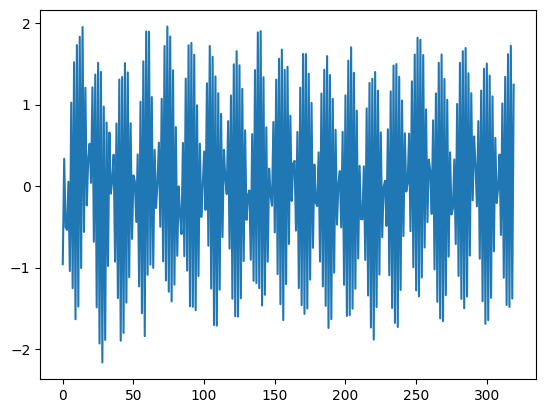

Idx  1


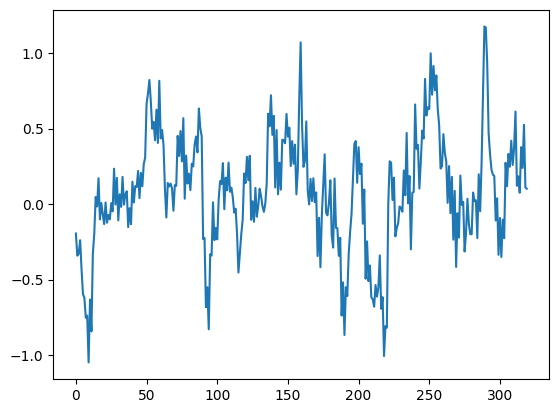

Idx  2


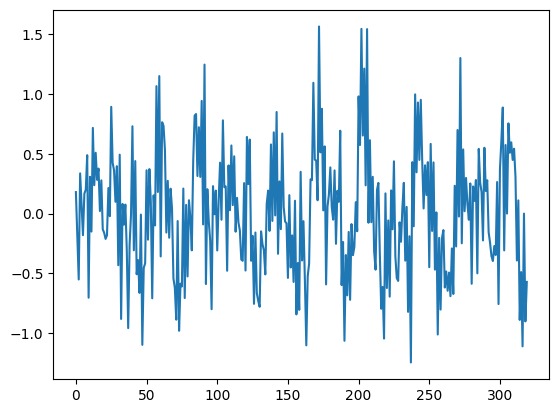

Idx  3


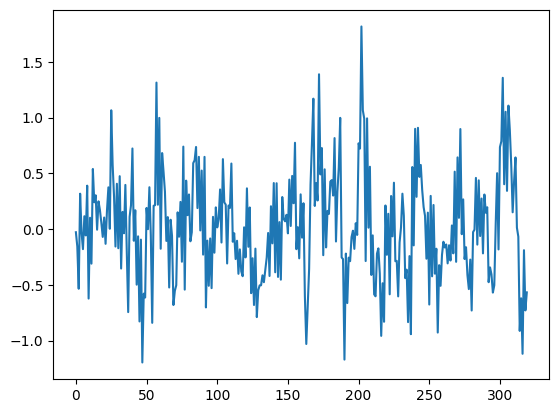

Idx  4


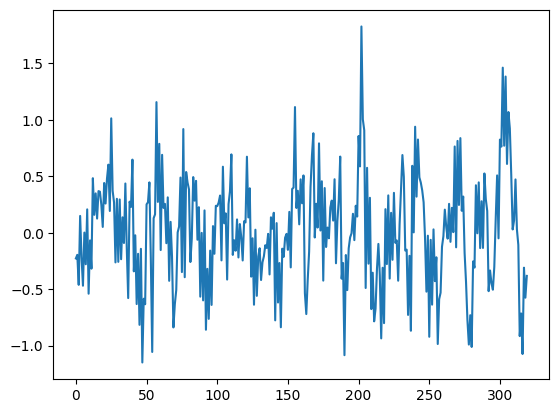

Idx  5


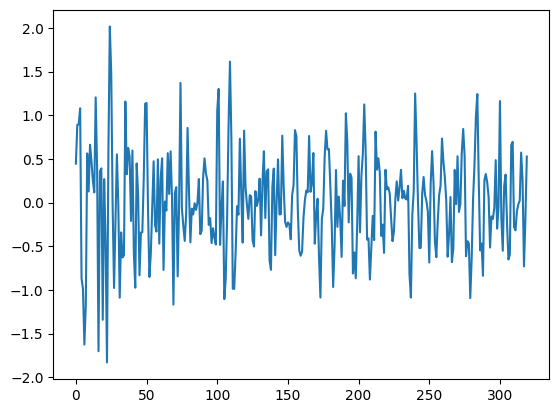

Idx  6


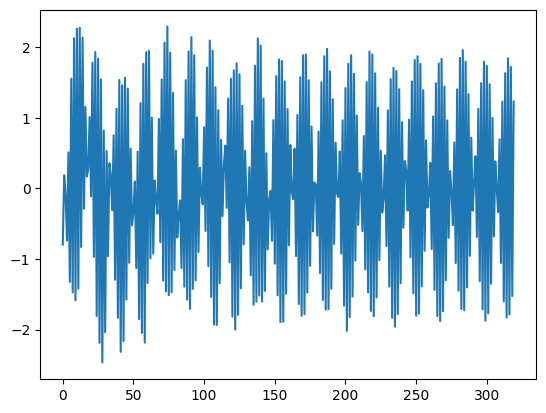

Idx  7


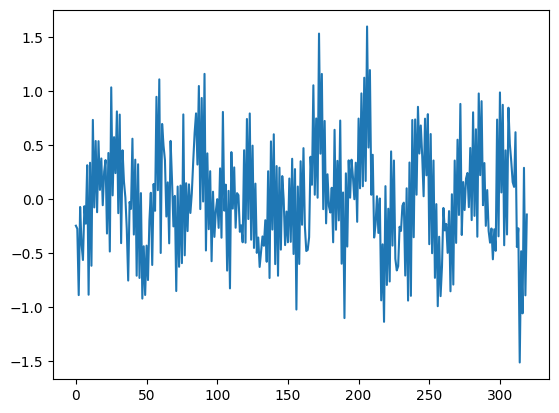

Idx  8


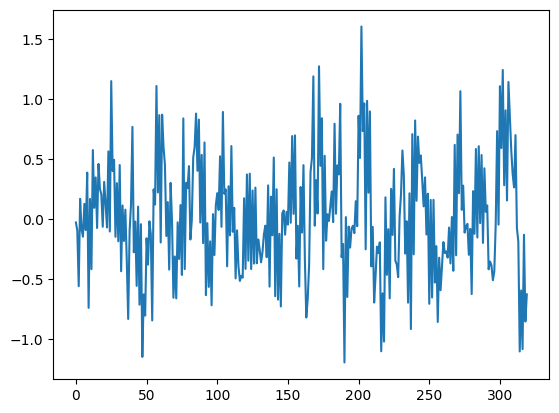

Idx  9


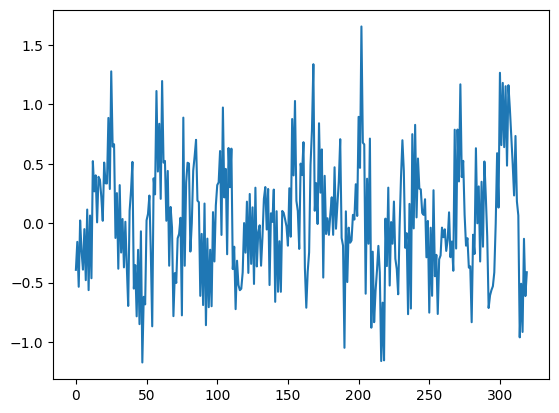

Idx  10


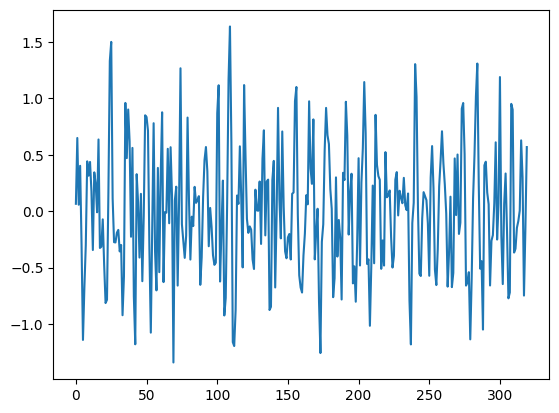

In [26]:
i = 50
window = slice(128*i, int(128*(i + params.model_epoch_len)))
for i, row in enumerate(eeg_emg):
    print("Idx ", i)
    plt.plot(row[window])
    plt.show()